### Lora vs Soft-prompting evaluation

Run ```train_finetuning.py``` to produce checkpoints to compare with this notebook.

Or download checkpoints from [google drive](https://drive.google.com/drive/folders/1cnyE_TMa3EPcfJy68xncmLGaqnZg0C91?usp=sharing) and
put them in the ```model``` folder (seen from the project root).

### Imports

In [7]:
%load_ext autoreload
%autoreload 2

from metrics import (
    SquaredError,
    FunctionClassError,
)

from models.baselines import ChebyshevKernelLinearRegression_LeastSquares

from metrics.utils import post_process

from interactive import load_checkpoint_with_config

from function_classes import (
    FunctionClass,
    ChebyshevKernelLinearRegression,
)

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import torch

from typing import NamedTuple, Any, Iterable
from pathlib import Path

from parse import process_config_from_file, get_x_distribution
from utils import get_latest_checkpoint_path_from_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
METRIC = SquaredError()
NUM_BATCHES = 100 # Total examples = NUM_BATCHES * BATCH_SIZE = 12800
SAVE_FIGS = True
LOG_SCALE = False

BATCH_SIZE = 128
SEQ_LEN = 31
X_DIM = 1
Y_DIM = 1

x_distribution = get_x_distribution(batch_size=BATCH_SIZE,
                                    seq_len=SEQ_LEN,
                                    x_dim=X_DIM,
                                    init_kwargs={'type' : 'uniform'})

### Evaluation code

In [9]:
class ModelLoadSpecs(NamedTuple):
    name: str
    checkpoint_dir: Path

def evaluate_setup(base_model_specs: ModelLoadSpecs, finetuned_models_specs: list[ModelLoadSpecs]):

    model_load_specs = [base_model_specs] + finetuned_models_specs

    processed_config, parsed_config = process_config_from_file(filename=str(model_load_specs[-1].checkpoint_dir / "config.yml"),
                                                           include=None,
                                                           checkpoint_path=str(get_latest_checkpoint_path_from_dir(model_load_specs[0].checkpoint_dir)),
                                                           resume_training=False)

    #base_fc: FunctionClass = processed_config['function_classes'][-1] # Choose the last function class from curriculum
    MAX_DEGREE = parsed_config['function_class']["highest_degree"]
    base_fc = ChebyshevKernelLinearRegression(lowest_degree=parsed_config['function_class']["lowest_degree"],
                                              highest_degree=MAX_DEGREE,
                                              fixed_linear_coefficients=parsed_config['function_class']["fixed_linear_coefficients"],
                                              different_degrees=parsed_config['function_class']["different_degrees"],
                                              x_distribution=x_distribution)
    del processed_config # Make sure we don't use all memory on having a model in memory

    bench = FunctionClassError(METRIC, function_class=base_fc)

    MODELS = {
        load_specs.name: load_checkpoint_with_config(str(load_specs.checkpoint_dir / "config.yml"), 
                                                    str(get_latest_checkpoint_path_from_dir(load_specs.checkpoint_dir)), 
                                                    import_configs=False)
        for load_specs in model_load_specs
    }
    MODELS.update({
        f"Poly. Regr. Degree {MAX_DEGREE},": ChebyshevKernelLinearRegression_LeastSquares(max_degree=MAX_DEGREE, x_dim=X_DIM, y_dim=Y_DIM),
    #    f"Poly. Regr. Degree {MAX_DEGREE}, Ridge=0.2": ChebyshevKernelLinearRegression_LeastSquares(ridge=0.2, max_degree=MAX_DEGREE, x_dim=X_DIM, y_dim=Y_DIM),
    })

    errs = bench.evaluate(MODELS.values(), num_batches=NUM_BATCHES)
    values = list(post_process(errs, confidence_level=[0.01]))

    return dict(zip(MODELS.keys(), values),)

### Plotting code

In [10]:
def plot_results(ax: Axes, eval_data: dict[str, dict[str, torch.Tensor]], title: str = "", 
                 hide_y_axis: bool = False, y_bottom: float = 1e-4, y_top: float = 5.0,
                 log_scale: bool = True):

    for name, results in eval_data.items():

        ax.plot(results["accuracy"], label=f"{name}")
        ax.fill_between(range(len(results["accuracy"])), results["confidence_0.01_lower"][:, 0], results["confidence_0.01_upper"][:, 0], alpha=0.2)
        
    if log_scale:
        ax.set_yscale("log")
        ax.set_ylim(bottom=y_bottom, top=y_top)
        
    ax.grid()
    ax.set_title(title)

    if hide_y_axis:
        ax.tick_params(labelleft=False)

    return ax

### Paths

In [11]:
parent_checkpoint_dir = Path().resolve().parent / "models"
base_model_specs = ModelLoadSpecs(name='Pretrained Model', checkpoint_dir=parent_checkpoint_dir / "poly_base_model")

### Base model and soft prompt learning rates

Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable parameters: 12800
Backbone model Unknown_ContextModel initialized with 1211009 trainable parameters
SoftPromptingGPT2Model trainable param

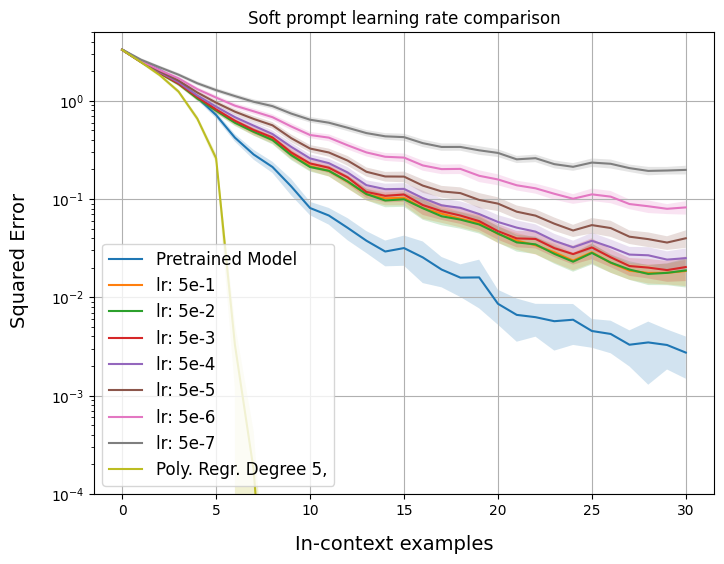

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# 0 Fixed coefficients
fine_tune_specs: list[ModelLoadSpecs] = [ModelLoadSpecs(name='lr: 5e-1', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_5"),
                                         ModelLoadSpecs(name='lr: 5e-2', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0"),
                                         ModelLoadSpecs(name='lr: 5e-3', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_005"),
                                         ModelLoadSpecs(name='lr: 5e-4', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_0005"),
                                         ModelLoadSpecs(name='lr: 5e-5', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_00005"),
                                         ModelLoadSpecs(name='lr: 5e-6', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_000005"),
                                         ModelLoadSpecs(name='lr: 5e-7', checkpoint_dir=parent_checkpoint_dir / "poly_soft_prompting_50_model_fixed_0_lr_0_0000005")]

eval_data = evaluate_setup(base_model_specs, finetuned_models_specs=fine_tune_specs)

plot_results(ax, eval_data, title="Soft prompt learning rate comparison", hide_y_axis=False, log_scale=LOG_SCALE)
fig.supxlabel("In-context examples", fontsize=14)
fig.supylabel("Squared Error", fontsize=14)
ax.legend(fontsize='large')
name_ending = ".pdf" if LOG_SCALE else "_mse_scale.pdf"
if SAVE_FIGS:
    fig.savefig("figures/lr_soft_prompt_comparison" + name_ending, format="pdf")
